## Coupling LLM-HSM with FIRETEC/QuickFire
Elchin Jafarov 
9/2020

In [1]:
import numpy as np
#import hsiscore_class as HSI
import hsiscore_class as HSI
import LLM_model_class as llm
#import LLM_model_cpy as llm
import hsi_plot_utils as hsi_plt
import matplotlib.pyplot as plt
import time
import pandas as pd
import random
import LLM_FT_utils as llmft
%matplotlib inline
hsi=HSI.hsi_score()

### 1. Running LLM model from scratch 

Also, to produce similar runs, we can freeze/turnoff the random number generation. The toggle 'randfromfile=0 or 1' will change betwen random and determinitstic modes. Note: that high dimensions (p.dim=80) will take some time to finish. 

In [2]:
# --spinup run ---
p = llm.LLM()     # assign p to the llm class
#NOTE: p.instantiate(1) assumes that runs correspoding input files do exist if not then run
p.dim = 80
p.instantiate(0)  # 1: reads input data from file, 0: generate inputs internally
p.readfireprobfromfile=0
p.readmastprobfromfile=0
p.verbose=0

start_time = time.time()
p.run(10) # here 200 is a number of years
print("--- %s seconds ---" % (time.time() - start_time))
p.save_pickle() #saves the results

no. of starting LLP trees 1246
no. of starting HW trees 649
--- 242.22878313064575 seconds ---


Once the spin-up is over we run the tansient run 

In [2]:
# --transient run ---
#del p
p = llm.LLM() 
p.dim = 80
p.randfromfile=0
p.instantiate(1)  # 1: reads input data from file, 0: generate inputs internally
p.verbose=0       # 0: do not print out scores, 1: print scores on the screen
p.tree_mature_age=10
p.readfireprobfromfile=0
p.readmastprobfromfile=0

start_time = time.time()
p.run(10)
print("--- %s seconds ---" % (time.time() - start_time))
if np.sum(p.litter)==0:
    print('no litter, making extra run...')
    p.fire_prob=0
    p.run(1)

#p.save_randfromfile()

no. of starting LLP trees 1280
no. of starting HW trees 651
no. of starting LLP trees read from file: 26849.0
no. of starting HW trees read from file: 2231.0
Data read from files!
--- 218.17318606376648 seconds ---
no litter, making extra run...


### 2. LLM to FireTec
First, we calculate the dbh and crown radius for LLPs and HWs.

/Users/elchin/Documents/Adams_project/llm-hsm-ft/1.LLM-HSM-MODEL/LLM_FT_utils.py:88: RuntimeWarning: divide by zero encountered in log
  y = a1+a2*np.log(H-1.37)
/Users/elchin/Documents/Adams_project/llm-hsm-ft/1.LLM-HSM-MODEL/LLM_FT_utils.py:100: RuntimeWarning: divide by zero encountered in log
  y = np.log(dbh)-a1-a2*np.log(H-1.37)
/Users/elchin/Documents/Adams_project/llm-hsm-ft/1.LLM-HSM-MODEL/LLM_FT_utils.py:100: RuntimeWarning: invalid value encountered in subtract
  y = np.log(dbh)-a1-a2*np.log(H-1.37)


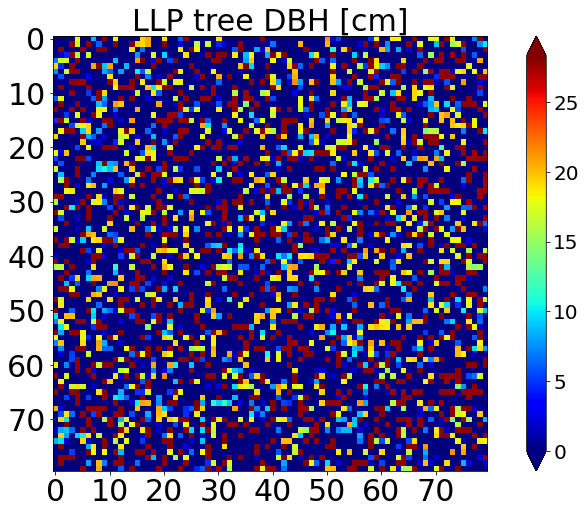

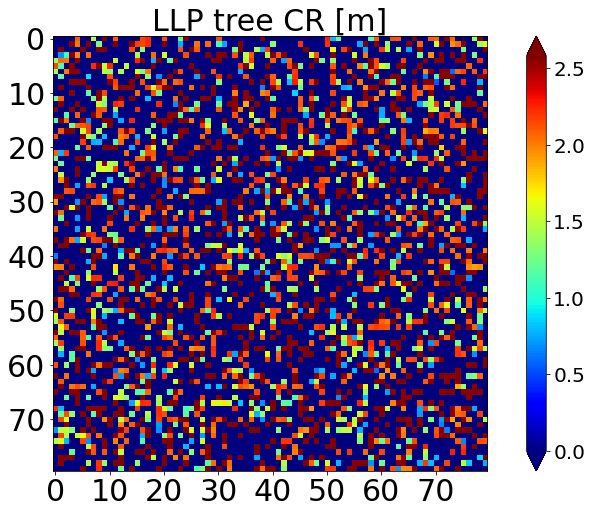

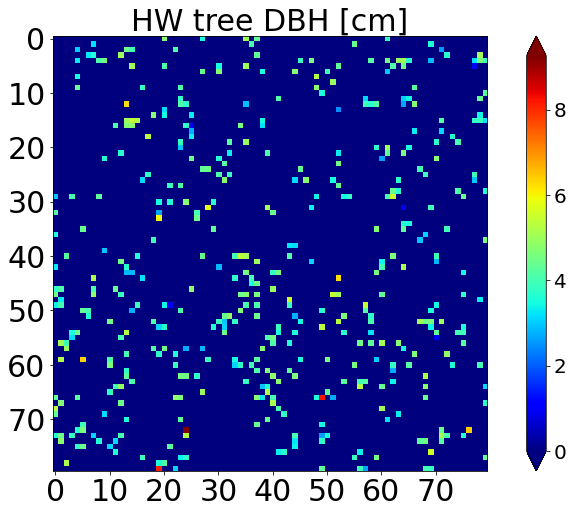

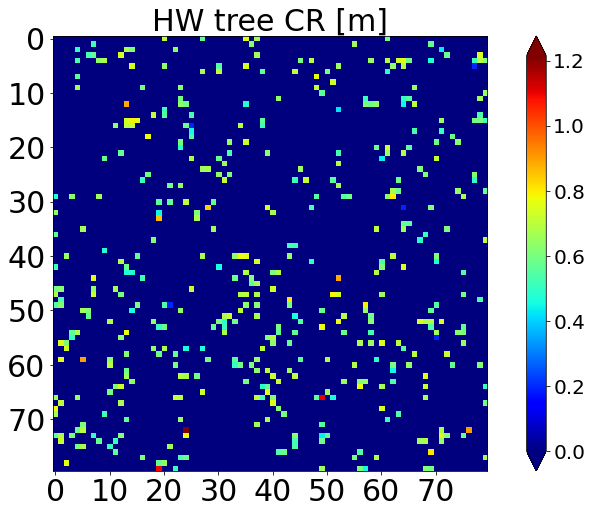

In [4]:
lp_count=p.old_LPcount.copy()
lp_count[p.old_ht<1.37]=0

lp_height=p.old_ht.copy()
lp_height[lp_height<1.37]=1.37
p.lp_dbh=llmft.dbh1_model(lp_height)
#print dbh
axx=llmft.plot_area_matrix(p.lp_dbh,'LLP tree DBH [cm]','yes')

lp_CA=llmft.dbh2_model(lp_height,p.lp_dbh)
p.lp_CR=np.sqrt(lp_CA/np.pi) #LLP Crown Area
all_NaNs = np.isnan(p.lp_CR)
p.lp_CR[all_NaNs] = 0
axx=llmft.plot_area_matrix(p.lp_CR,'LLP tree CR [m]','yes')

hw_height=p.old_htHW.copy()
hw_height[hw_height<1.37]=1.37
p.hw_dbh=llmft.dbh1_model(hw_height)
#print dbh
axx=llmft.plot_area_matrix(p.hw_dbh,'HW tree DBH [cm]','yes')

hw_CR=llmft.dbh2cr_hw(p.hw_dbh/2.54) # note dbh is in inch
p.hw_CR=hw_CR/3.281            # CR is in feet convert to meters
all_NaNs = np.isnan(p.hw_CR)
p.hw_CR[all_NaNs] = 0
axx=llmft.plot_area_matrix(p.hw_CR,'HW tree CR [m]','yes') 

In [30]:
!python DRM_framework_coupling.py 10 'LLM2FT'

Run time [years]: 10
Folder name: LLM2FT
--------------------------
no. of starting LLP trees 1291
no. of starting HW trees 612
Running LLM spinup for 10  years....
--- spinup 213.41839408874512 seconds ---
no. of starting LLP trees 1303
no. of starting HW trees 608
no. of starting LLP trees read from file: 26849.0
no. of starting HW trees read from file: 2231.0
Data read from files!
Running LLM transient for 10  years....
--- transient 315.59079599380493 seconds ---
no litter, making an extra run...
End of spinup and transient runs
--------------------------

/Users/elchin/Documents/Adams_project/llm-hsm-ft/1.LLM-HSM-MODEL/LLM_FT_utils.py:88: RuntimeWarning: divide by zero encountered in log
  y = a1+a2*np.log(H-1.37)
/Users/elchin/Documents/Adams_project/llm-hsm-ft/1.LLM-HSM-MODEL/LLM_FT_utils.py:100: RuntimeWarning: divide by zero encountered in log
  y = np.log(dbh)-a1-a2*np.log(H-1.37)
/Users/elchin/Documents/Adams_project/llm-hsm-ft/1.LLM-HSM-MODEL/LLM_FT_utils.py:100: RuntimeWar

#### 2.1 Regrid LLM litters (80x80), each cell area 25m2  and save them in FT format (200x200), 4m2 cell area

shape of the litter matrix: 80 80
sum of the old litter matrix: 9211.897239452595
sum of the old litter matrix: 57585.11991838006
litter file: LLM2FT/LLM_litter_WG.dat  saved!
shape of the litter matrix: 80 80
sum of the old litter matrix: 26291.3506282065
sum of the old litter matrix: 164288.51143008203
litter file: LLM2FT/LLM_litter_trees.dat  saved!
lit_LLP%, lit_HW%: 0.9989456707707917 0.0010543292292084015


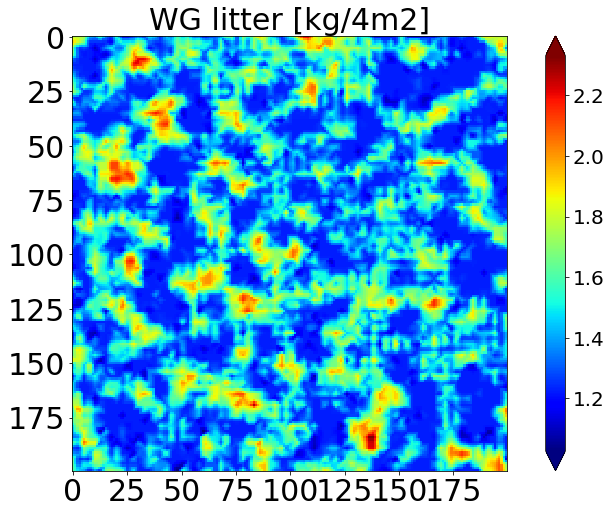

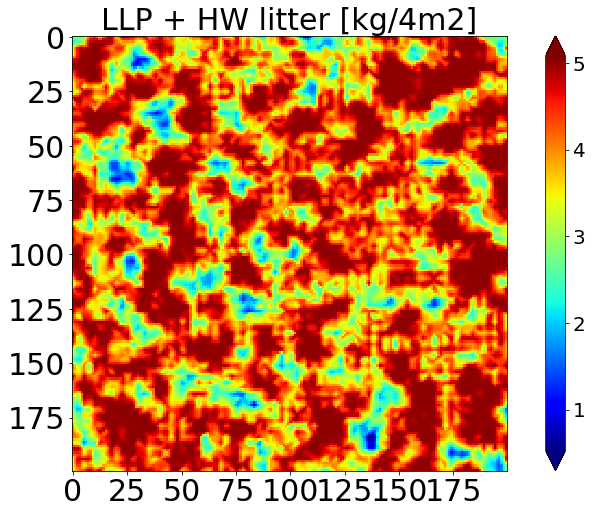

In [20]:
#filename='First_Fire_Runs/HI-P-ET-FIRE1-LLM2FT/LLM_litter_WG.dat'
#filename='First_Fire_Runs/LOW-P-ET-FIRE1-LLM2FT/LLM_litter_WG.dat'
filename='LLM2FT/LLM_litter_WG.dat'
ftitle='WG litter [kg/4m2]'
llmft.save_litter_LLM_FT(filename,ftitle,p.litterWG,'plot')

#filename='First_Fire_Runs/HI-P-ET-FIRE1-LLM2FT/LLM_litter_tree.dat'
#filename='First_Fire_Runs/LOW-P-ET-FIRE1-LLM2FT/LLM_litter_tree.dat'
filename='LLM2FT/LLM_litter_trees.dat'
ftitle='LLP + HW litter [kg/4m2]'
tree_litter=p.litterHW+p.litter
llmft.save_litter_LLM_FT(filename,ftitle,tree_litter,'plot')

percent_LP_litter=np.sum(p.litter)/np.sum(p.litterHW+p.litter)
percent_HW_litter=np.sum(p.litterHW)/np.sum(p.litterHW+p.litter)
print ('lit_LLP%, lit_HW%:',percent_LP_litter,percent_HW_litter)
#print ('lit_LLP%, lit_HW%')
#print (np.sum(p.litter)/np.sum(p.litterHW+p.litter), np.sum(p.litterHW)/np.sum(p.litterHW+p.litter))

#### 2.2 Make treelist file for the first run 

shape of llp (x,y): (2701, 6)
shape of hw (x,y): (770, 6)
LLM2FT/treelist_LLM.dat is created!


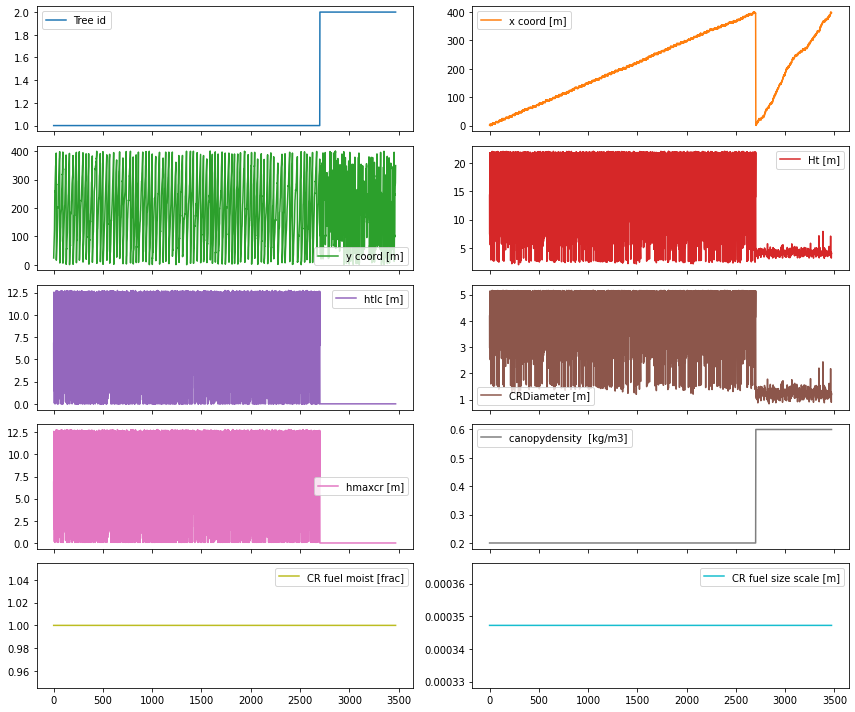

In [6]:
llmft.create_treelist(p,'LLM2FT/treelist_LLM.dat')
#check the created treelist file
# see line 124 in define_variables.f in Tree program
# Tree ID [1:LLP, 2:HW]
# x coord: Tree X-cartesian coordinates [m,m]
# y coord: Tree Y-cartesian coordinates [m,m]
# Ht: Tree heights [m]
# htlc: Height to live crown [m]
# CRDiameter: Crown diameter [m]
# hmaxcr: Height to max crown diameter [m]
# canopydensity: Crown fuel bulk density [kg/m3]
# CR fuel moist: Crown fuel moisture content [fraction]
# CR fuel size scale:  Crown fuel size scale [m]

df = pd.read_csv('LLM2FT/treelist_LLM.dat',sep=' ',
                    names=["Tree id","x coord [m]","y coord [m]","Ht [m]",
                        "htlc [m]","CRDiameter [m]","hmaxcr [m]",
                        "canopydensity  [kg/m3]", "CR fuel moist [frac]",
                        "CR fuel size scale [m]" ]) 
df.plot(subplots=True, layout=(5,2),figsize=(12, 10));
plt.tight_layout()

Total number of trees:  3471


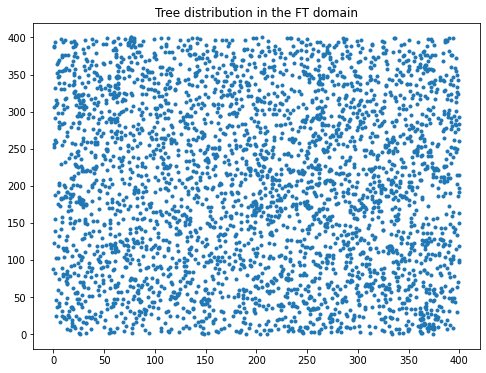

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(df["x coord [m]"].values,df["y coord [m]"].values,'.')
plt.title('Tree distribution in the FT domain');
print("Total number of trees: ",df["x coord [m]"].size )

Once we have all three files ..._litter_tree.dat, ..._litter_WG.dat and treelist_LLM.dat we can pass them to the Tree code which would calculate FT input files.

### 3. FireTec to LLM (cyclical)  
After the FT finishes its run, we convert back to the LLM-HSM format and run the LLM-HSM model with no fire. Then convert litters back to FT. Here we need to re-calculate treelist, since after LLM-HSM number of trees per cell could change.

FT tree litter size : 200 200
FT tree litter sum (2m2 res): 109814.87999999999
LLM tree litter sum (5m2 res): 18356.398481012686
FT WG litter size : 200 200
FT WG litter sum (2m2 res): 23531.760000000002
LLM WG litter sum (5m2 res): 3936.688101265829
number FT of trees in treelist:  4450
total LLM tree count:  4450.0
number FT of trees in treelist:  967
total LLM tree count:  967.0
--- 967.6410791873932 seconds ---
80 80
4695.346833432717
28067.309073612316
(200, 200)
80 80
62889.192128670664
387377.2140883894
(200, 200)
lit_LLP%, lit_HW%
0.9969722302605478 0.003027769739452387


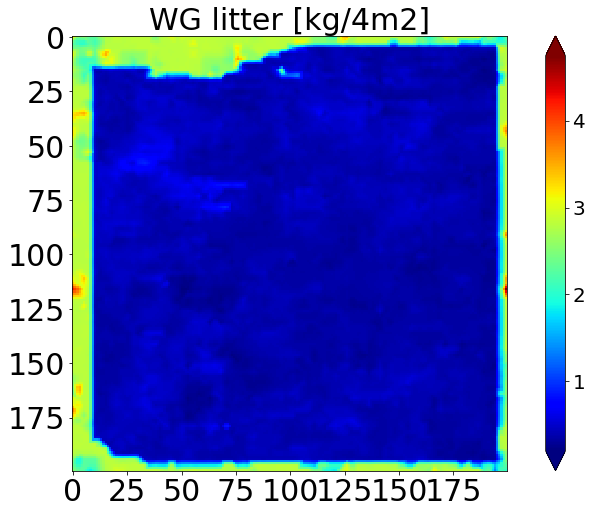

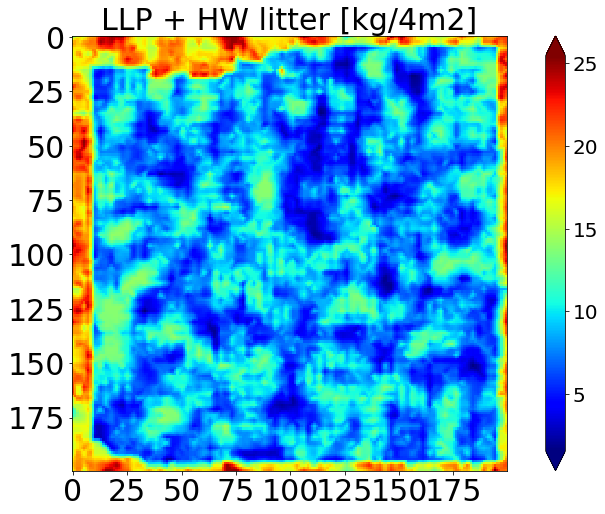

In [11]:
flitter='FT2LLM/AfterFireLitter.txt'
fwg='FT2LLM/AfterFireWG.txt'
ftlist='FT2LLM/AfterFireTrees.txt'
p=llmft.read_FT_2_LLM(flitter,fwg,ftlist,p)

#run the LLM-HSI for 5 years
p.fire_prob=0
start_time = time.time()
p.run(5)
print("--- %s seconds ---" % (time.time() - start_time))

#save new FT littes files
filename='FT2LLM/LLM_litter_WG.dat'
ftitle='WG litter [kg/4m2]'
llmft.save_litter_LLM_FT(filename,ftitle,p.litterWG)

filename='FT2LLM/LLM_litter_tree.dat'
ftitle='LLP + HW litter [kg/4m2]'
tree_litter=p.litterHW+p.litter
llmft.save_litter_LLM_FT(filename,ftitle,tree_litter)

LLPlit_per=np.sum(p.litter)/np.sum(p.litterHW+p.litter)
HWlit_per=np.sum(p.litterHW)/np.sum(p.litterHW+p.litter)

print ('lit_LLP%, lit_HW%')
print (LLPlit_per,HWlit_per) 

/Users/l316071/Documents/hvi-score-10/LLM-HSM-FT-coupling/LLM_FT_utils.py:88: RuntimeWarning: divide by zero encountered in log
  y = a1+a2*np.log(H-1.37)
/Users/l316071/Documents/hvi-score-10/LLM-HSM-FT-coupling/LLM_FT_utils.py:100: RuntimeWarning: divide by zero encountered in log
  y = np.log(dbh)-a1-a2*np.log(H-1.37)
/Users/l316071/Documents/hvi-score-10/LLM-HSM-FT-coupling/LLM_FT_utils.py:100: RuntimeWarning: invalid value encountered in subtract
  y = np.log(dbh)-a1-a2*np.log(H-1.37)


number of LLPs: 3376.0
number of HWs: 442.0
tt_llp: (4450, 6)
lplist: (4548, 6)
tt_hw: (967, 6)
hwlist: (1006, 6)
lp_newlist (3133, 6)
hw_newlist (211, 6)
(3344, 8)


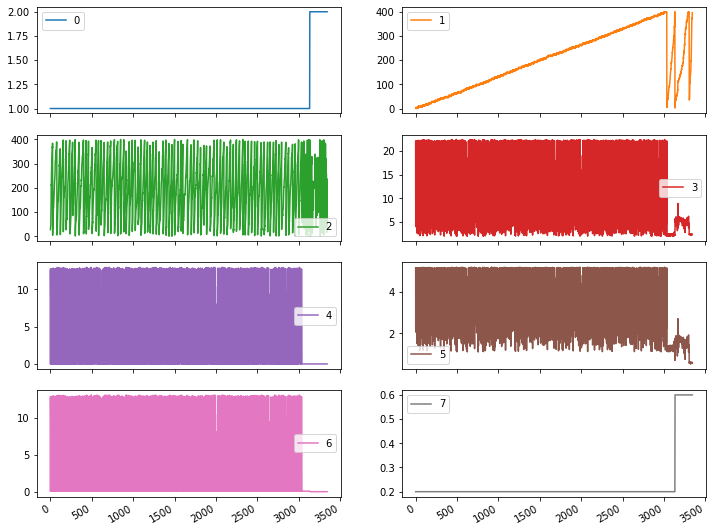

In [12]:
ftlist='FT2LLM/AfterFireTrees.txt'
[lp_list,hw_list]=llmft.update_tree_info_per_location(p,ftlist,0)

df_hw = pd.DataFrame(hw_list)
df = pd.DataFrame(lp_list)
df=df.append(df_hw)
#df.plot(subplots=True, layout=(4,2),figsize=(12, 10));
df.to_csv('treelist_LLM.dat', sep=' ',header=False,index=False)

file_in='treelist_LLM.dat'
file_out='FT2LLM/treelist_LLM.dat'
llmft.save_FT_treelist(file_in,file_out,1)

Now repreat step 3 every time when FT finishes it run 

### 4. Running the Tree Program  
To run the Tree Programm we need three files:'LLM_litter_WG.dat', 'FT2LLM/LLM_litter_tree.dat', and 'treelist_LLM.dat'. The configration files is 'Inputs/fuellist'. Includes the dimensions of the litter and WG domain sizes. itrees=2, igrass=2, ilitter=2 indicates that it will be reading those parameters from the correspoding files. Copy files from 'FT2LLM' to the '2.Tree_code' folder. 

In [52]:
m=np.loadtxt('../1.LLM-HSM-MODEL/FT2LLM/LLM_litter_WG.dat')
m1=np.loadtxt('pervious_tree_file_EJ/LLM_litter_WG.txt')
m2=np.loadtxt('pervious_tree_file_EJ/treelist.txt')
m21=np.loadtxt('Inputs/treelist.txt')
m3=np.loadtxt('../1.LLM-HSM-MODEL/LLM2FT/treelist_LLM.dat')

In [16]:
m=np.loadtxt('FT2LLM/LLM_litter_WG.dat')

In [18]:
m

array([[0.3 , 0.3 , 0.3 , ..., 0.3 , 0.3 , 0.3 ],
       [0.31, 0.31, 0.3 , ..., 0.3 , 0.3 , 0.3 ],
       [0.32, 0.31, 0.3 , ..., 0.32, 0.3 , 0.29],
       ...,
       [0.27, 0.25, 0.23, ..., 0.34, 0.31, 0.29],
       [0.27, 0.26, 0.24, ..., 0.34, 0.32, 0.29],
       [0.27, 0.26, 0.25, ..., 0.34, 0.32, 0.3 ]])

In [17]:
print (m.shape)
#print (m1.shape)
#print (m21.shape)
#print (m2.shape)
#print (m3.shape)

(200, 200)


In [43]:
ls ../1.LLM-HSM-MODEL/LLM2FT/

litter_WG.dat     litter_tree.dat   treelist_LLM.dat


In [3]:
ls -la LLM2FT/

total 1192
drwxr-xr-x@  5 elchin  staff     160 Mar 30 20:39 ./
drwxr-xr-x@ 17 elchin  staff     544 Apr 13 10:32 ../
-rw-r--r--   1 elchin  staff  200000 Mar 30 16:23 litter_WG.dat
-rw-r--r--   1 elchin  staff  200000 Mar 30 16:23 litter_tree.dat
-rw-r--r--@  1 elchin  staff  137640 Mar 30 16:23 treelist_LLM.dat


In [7]:
cd ../2.Tree_code/

/Users/elchin/Documents/Adams_project/llm-hsm-ft/2.Tree_code


In [41]:
import subprocess
status=subprocess.call(["./trees"])
if status==0:
    print('Tree program run successfully!')
else:
    print('Tree program failed to execute...')

Tree programm run successfully!


In [ ]:
# running the Tree program from here
! ./trees 

Tree program generate the following dat files

In [11]:
ls *.dat

treesfueldepth.dat  treesmoist.dat      treesrhof.dat       treesss.dat


In [23]:
import struct

def read_dat_file(filename):
    # Read all of the data
    with open(filename, 'rb') as input_file:
        data = input_file.read()

    # Convert to list of floats
    format = '{:d}f'.format(len(data)//4)
    data = struct.unpack(format, data)

    # Display some of the data
    print (len(data), "entries")
    print (data[0], data[1], data[2], "...")
    
    return data

In [29]:
print("Read trees fuel depth")
treesfueldepth=read_dat_file('treesfueldepth.dat')
print()
print("Read trees moisture")
treesmoist=read_dat_file('treesmoist.dat')
print()
print("Read trees rhof")
treesrhof=read_dat_file('treesrhof.dat')
print()
print("Read trees ss")
treesss=read_dat_file('treesss.dat')

Read trees fuel depth
420008 entries
5.885453550164232e-40 0.27000001072883606 0.27000001072883606 ...

Read trees moisture
5040008 entries
7.062544260197078e-39 0.05999999865889549 0.05999999865889549 ...

Read trees rhof
5040008 entries
7.062544260197078e-39 0.5568188428878784 0.5568188428878784 ...

Read trees ss
5040008 entries
7.062544260197078e-39 0.0005000000237487257 0.0005000000237487257 ...


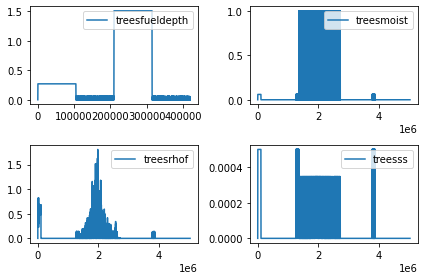

In [40]:
plt.subplot(2, 2, 1)
plt.plot(treesfueldepth,label='treesfueldepth')
plt.legend(['treesfueldepth'],loc="best")
plt.subplot(2, 2, 2)
plt.plot(treesmoist,label='treesmoist')
plt.legend(['treesmoist'],loc="best")
plt.subplot(2, 2, 3)
plt.plot(treesrhof,label='treesrhof')
plt.legend(['treesrhof'],loc="best")
plt.subplot(2, 2, 4)
plt.plot(treesss,label='treesss')
plt.legend(['treesss'],loc="best")
plt.tight_layout();